In [1]:
%cd /proj/azizpour-group/users/x_amime/projects/an_explanation_model

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial

from source.project_manager import (
    load_experiment_inconsistency,
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from commands.experiment_6_1 import (
    save_metadata_dir,
    dataset_dir,
    input_shape,
    save_output_dir,
)

os.makedirs(save_output_dir, exist_ok=True)
from source.data_manager import (
    preprocess_masks,
    plot_masks,
    minmax_normalize,
    sum_channels,
    symmetric_minmax_normalize,
    single_query_imagenet,
    save_axis,
)
from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "jet"}

query_imagenet = partial(
    single_query_imagenet, dataset_dir=dataset_dir, input_shape=input_shape
)

2024-02-07 10:18:19.306512: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 10:18:19.550009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 10:18:19.551613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 10:18:21.874945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project_metadata = load_experiment_metadata(save_metadata_dir, glob_path="merged_sl_metadata.csv")
print(project_metadata.columns)
project_metadata = project_metadata.set_index(
    [
        "image_index",
        "stream_name",
        "stream_statistic",
        "baseline_mask_type",
        "alpha_mask_value",
    ]
).sort_index()
print(project_metadata.shape)

Index(['image_index', 'data_path', 'image_path', 'label', 'baseline_mask_type',
       'alpha_mask_value', 'stream_name', 'stream_statistic',
       'ig_elementwise'],
      dtype='object')
(100, 4)


In [6]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))
image_indices = project_metadata.index.get_level_values("image_index").unique()

image_index  stream_name        stream_statistic  baseline_mask_type  alpha_mask_value
0            vanilla_grad_mask  meanx2            gaussian-0.3        sl_u_0_0.5          1
63           vanilla_grad_mask  meanx2            gaussian-0.3        sl_u_0_0.5          1
73           vanilla_grad_mask  meanx2            gaussian-0.3        sl_u_0_0.5          1
72           vanilla_grad_mask  meanx2            gaussian-0.3        sl_u_0_0.5          1
71           vanilla_grad_mask  meanx2            gaussian-0.3        sl_u_0_0.5          1
                                                                                         ..
30           vanilla_grad_mask  meanx2            gaussian-0.3        sl_u_0_0.5          1
29           vanilla_grad_mask  meanx2            gaussian-0.3        sl_u_0_0.5          1
28           vanilla_grad_mask  meanx2            gaussian-0.3        sl_u_0_0.5          1
27           vanilla_grad_mask  meanx2            gaussian-0.3        sl_u_0_0.5     

In [7]:
for name in project_metadata.index.names:
    print(
        name,
        "=",
        project_metadata.index.get_level_values(name).value_counts().to_dict(),
    )

image_index = {0: 1, 63: 1, 73: 1, 72: 1, 71: 1, 70: 1, 69: 1, 68: 1, 67: 1, 66: 1, 65: 1, 64: 1, 62: 1, 1: 1, 61: 1, 60: 1, 59: 1, 58: 1, 57: 1, 56: 1, 55: 1, 54: 1, 53: 1, 52: 1, 74: 1, 75: 1, 76: 1, 77: 1, 98: 1, 97: 1, 96: 1, 95: 1, 94: 1, 93: 1, 92: 1, 91: 1, 90: 1, 89: 1, 88: 1, 87: 1, 86: 1, 85: 1, 84: 1, 83: 1, 82: 1, 81: 1, 80: 1, 79: 1, 78: 1, 51: 1, 50: 1, 49: 1, 24: 1, 22: 1, 21: 1, 20: 1, 19: 1, 18: 1, 17: 1, 16: 1, 15: 1, 14: 1, 13: 1, 12: 1, 11: 1, 10: 1, 9: 1, 8: 1, 7: 1, 6: 1, 5: 1, 4: 1, 3: 1, 2: 1, 23: 1, 25: 1, 48: 1, 26: 1, 47: 1, 46: 1, 45: 1, 44: 1, 43: 1, 42: 1, 41: 1, 40: 1, 39: 1, 38: 1, 37: 1, 36: 1, 35: 1, 34: 1, 33: 1, 32: 1, 31: 1, 30: 1, 29: 1, 28: 1, 27: 1, 99: 1}
stream_name = {'vanilla_grad_mask': 100}
stream_statistic = {'meanx2': 100}
baseline_mask_type = {'gaussian-0.3': 100}
alpha_mask_value = {'sl_u_0_0.5': 100}


In [8]:
explanations_mean_freq = project_metadata["data_path"].apply(
    np.load)

In [9]:
temp_indices = image_indices[2:5]
temp_freqs = explanations_mean_freq[temp_indices]

2024-02-07 10:19:45.158824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000]
	 [[{{node Placeholder/_1}}]]
2024-02-07 10:19:45.159051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000]
	 [[{{node Placeholder/_1}}]]
2024-02-07 10:19:54.109917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000

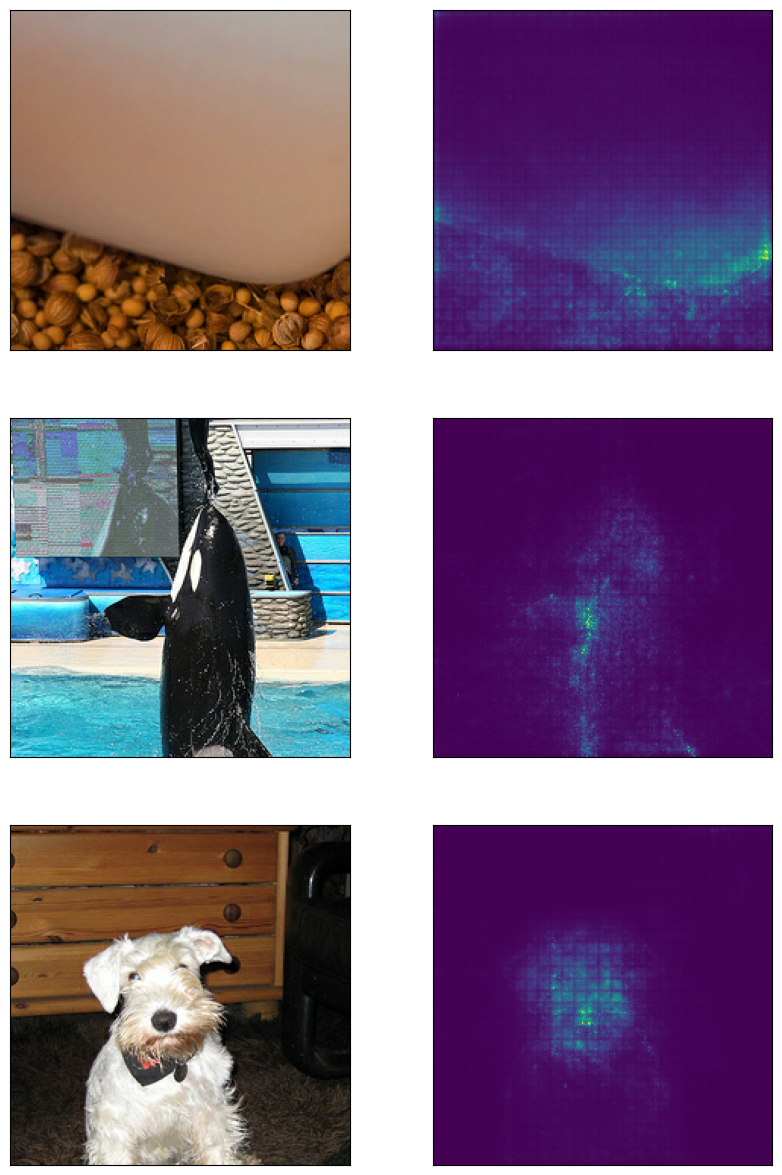

In [11]:
n_cols = 2
n_rows = 3
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 5 * n_rows),
)
axes = axes.flatten()
i = 0
names = []
for image_index, explanation_mean_freq in zip(temp_indices, temp_freqs):
    if i >= axes.size:
        break
    original_image, label, image_path = query_imagenet(skip=image_index)

    axes[i].imshow(np.squeeze(original_image))
    clean_label = IMAGENET_LABELS[label]
    clean_label = clean_label.split(",")[0]
    # axes[i].set_title(f"label: {clean_label}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    # names.append(f"image_index {image_index} original image ({clean_label})")
    im_out = axes[i + 1].imshow(explanation_mean_freq.squeeze())
    # axes[i + 1].set_title("mean frequency")
    axes[i + 1].set_xticks([])
    axes[i + 1].set_yticks([])
    names.append(f"image_index {image_index} mean frequency ({clean_label})")

    i += 2

# save_axis(names=names, fig=fig, axes=axes, save_output_dir=save_output_dir)

In [28]:
temp_masks = explanations_temp.set_index(["image_index", "alpha_mask_value"])
temp_masks = temp_masks.loc[(slice(None), 0.2),"grad_mask"]
titles = temp_masks.index.to_series().apply(lambda x: f"image_index {x[0]} alpha {x[1]:.2f}")
temp_masks=temp_masks.apply(np.load)
temp_masks = preprocess_masks(temp_masks, preprocesses=[sum_channels, minmax_normalize])
imshow_args = {"cmap": "viridis"}
fig, axes = plot_masks(temp_masks, imshow_args=imshow_args, ncols=2)
# save_axis(titles, fig, axes, save_output_dir)

NameError: name 'explanations_temp' is not defined

In [13]:
image_index = 0
original_image, label, image_path = query_imagenet(image_index=image_index)

2024-01-23 12:36:15.914432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000]
	 [[{{node Placeholder/_1}}]]
2024-01-23 12:36:15.914726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000]
	 [[{{node Placeholder/_1}}]]


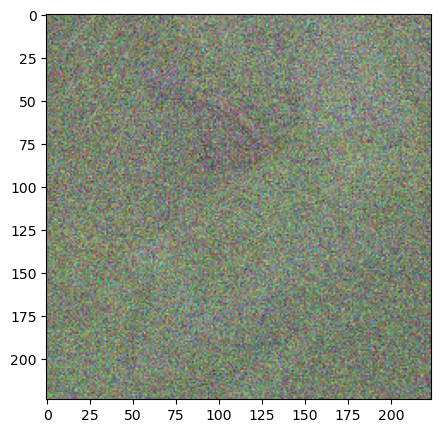

In [18]:
temp = original_image.copy()
for i in range(5):
    noise = np.random.randn(*original_image.shape)*0.1
    temp = temp + noise
    # normalize between 0 and 1
    temp = minmax_normalize(temp)

# show the image
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.imshow(temp.squeeze())